In [1]:
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from functools import partial
from random import sample

import os
import time
import graco
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

In [3]:
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)     
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)
    
if not os.path.exists(f"{CLUSTERS_DIRECTORY}/GDV"):
    os.makedirs(f"{CLUSTERS_DIRECTORY}/GDV")
    
if not os.path.exists(f"{CLUSTERS_DIRECTORY}/GCV"):
    os.makedirs(f"{CLUSTERS_DIRECTORY}/GCV")

# Distance matrices

In [4]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

## GDV-based

### GDV similarity

In [22]:
np.savetxt(f"{CPP_DIRECTORY}/matrix.in", GDV, 
           header=f"{len(GDV)} 15", fmt='%d')

In [23]:
D = np.genfromtxt(f"{CPP_DIRECTORY}/matrix.out")
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_similarity.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

#### Rest

In [20]:
all_distances = ['euclidean', 'cityblock', 'seuclidean', 'sqeuclidean', 
                 'cosine', 'correlation', 'chebyshev', 'canberra', 
                 'braycurtis', 'mahalanobis']

In [21]:
for distance in all_distances:
    D = cdist(GDV.values, GDV.values, distance)
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_{distance}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

## GCV-based

In [72]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GCV = graco.coefficients(PPI_nx)

### Hellinger - single

In [6]:
_SQRT2 = np.sqrt(2) 

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [7]:
for order,source in set((order,source) for order,source,target in GCV.columns):
    t1 = time.time()
    D = cdist(np.array(GCV[order][source]), np.array(GCV[order][source]), hellinger)
    t2 = time.time()
    print(f'{order}-{source}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_hellinger.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0-0: 242.75sec
-1-3: 245.51sec
3-3: 240.31sec
1-1: 236.50sec
-1-2: 239.88sec
-1-0: 237.58sec
-1-1: 236.89sec
1-2: 239.48sec
2-1: 239.23sec


### Hellinger - combination

In [9]:
D_list = []

for order,source in set((order,source) for order,source,target in GCV.columns):
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_hellinger.txt", delimiter=' ')
    D_list.append(np.array(df))

D = np.nanmean(D_list, axis=0)
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GCV_hellinger.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

### TVD - individual

In [8]:
for order,source in set((order,source) for order,source,target in GCV.columns):
    t1 = time.time()
    D = cdist(np.array(GCV[order][source]), np.array(GCV[order][source]), graco.functions.tvd)
    t2 = time.time()
    print(f'{order}-{source}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_tvd.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0-0: 165.49sec
-1-3: 161.96sec
3-3: 162.53sec
1-1: 162.82sec
-1-2: 162.89sec
-1-0: 161.32sec
-1-1: 162.55sec
1-2: 161.95sec
2-1: 160.59sec


### TVD - combination

In [11]:
D_list = []

for order,source in set((order,source) for order,source,target in GCV.columns):
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_tvd.txt", delimiter=' ')
    D_list.append(np.array(df))

D = np.nanmean(D_list, axis=0)
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GCV_TVD.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

### Rest

In [7]:
GCV = GCV.fillna(0)
all_distances = ['euclidean', 'cityblock', 'seuclidean', 'sqeuclidean', 
                 'cosine', 'correlation', 'chebyshev', 'canberra', 
                 'braycurtis', 'mahalanobis']

In [16]:
for distance in all_distances:
    D = cdist(GCV.values, GCV.values, distance)
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GCV_{distance}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

### Rest - individual

In [7]:
all_distances = ['euclidean', 'cityblock', 'sqeuclidean', 
                 'cosine', 'correlation', 'chebyshev', 'canberra', 
                 'braycurtis']

In [8]:
for distance in all_distances:
    for order,source in set((order,source) for order,source,target in GCV.columns):
        D = cdist(np.array(GCV[order][source]), np.array(GCV[order][source]), distance)
        print(f'{distance} {order: <2} {source}')  
        np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_{distance}.txt", D, 
                   fmt='%.7f', header=' '.join(PPI_nx), comments='')

-1-3: 0.13sec
0-0: 0.07sec
1-1: 0.12sec
3-3: 0.11sec
-1-1: 0.12sec
-1-0: 0.09sec
1-2: 0.11sec
2-1: 0.12sec
-1-2: 0.13sec
-1-3: 0.08sec
0-0: 0.07sec
1-1: 0.09sec
3-3: 0.10sec
-1-1: 0.10sec
-1-0: 0.06sec
1-2: 0.09sec
2-1: 0.10sec
-1-2: 0.09sec
-1-3: 0.22sec
0-0: 0.16sec
1-1: 0.25sec
3-3: 0.35sec
-1-1: 0.23sec
-1-0: 0.21sec
1-2: 0.25sec
2-1: 0.34sec
-1-2: 0.21sec
-1-3: 0.22sec
0-0: 0.07sec
1-1: 0.14sec
3-3: 0.16sec
-1-1: 0.18sec
-1-0: 0.08sec
1-2: 0.16sec
2-1: 0.16sec
-1-2: 0.15sec
-1-3: 0.10sec
0-0: 0.15sec
1-1: 0.22sec
3-3: 0.13sec
-1-1: 0.19sec
-1-0: 0.16sec
1-2: 0.20sec
2-1: 0.11sec
-1-2: 0.18sec
-1-3: 0.19sec
0-0: 0.19sec
1-1: 0.19sec
3-3: 0.21sec
-1-1: 0.11sec
-1-0: 0.22sec
1-2: 0.22sec
2-1: 0.19sec
-1-2: 0.20sec
-1-3: 0.09sec
0-0: 0.14sec
1-1: 0.19sec
3-3: 0.11sec
-1-1: 0.22sec
-1-0: 0.07sec
1-2: 0.16sec
2-1: 0.12sec
-1-2: 0.08sec
-1-3: 0.16sec
0-0: 0.13sec
1-1: 0.21sec
3-3: 0.23sec
-1-1: 0.30sec
-1-0: 0.13sec
1-2: 0.27sec
2-1: 0.32sec
-1-2: 0.18sec
-1-3: 0.19sec
0-0: 0.15sec
1-1: 

### Rest - combination

In [10]:
for distance in all_distances:
    D_list = []
    for order,source in set((order,source) for order,source,target in GCV.columns):
        df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_{distance}.txt", delimiter=' ')
        D_list.append(np.array(df))

    D = np.nanmean(D_list, axis=0)
    print(distance)
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_gGCV_{distance}.txt", D, 
                   fmt='%.7f', header=' '.join(PPI_nx), comments='')

euclidean
cityblock
seuclidean
sqeuclidean
cosine
correlation
chebyshev
canberra
braycurtis
mahalanobis


### Normalized $L_p$

In [21]:
def normalized_lp(P,Q,p=1):
    v1 = np.divide(P, P+Q, out=np.zeros_like(P), where=(P+Q)!=0)
    v2 = np.divide(Q, P+Q, out=np.zeros_like(Q), where=(P+Q)!=0)
    return np.linalg.norm(v1-v2,p)

def normalized_l1(P,Q):
    return normalized_lp(P,Q,1)

def normalized_l2(P,Q):
    return normalized_lp(P,Q,2)

def normalized_linf(P,Q):
    return normalized_lp(P,Q,np.inf)

In [67]:
p = 2

In [68]:
list_ = []
for a,b in product(np.linspace(0,1,10), repeat=2):
    v1 = np.array([a,1-b])
    v2 = np.array([b,1-b])
    
    v1 = np.where(v1<0,0,v1)
    v2 = np.where(v2<0,0,v2)
    
    list_.append(normalized_lp(v1,v2,p))
print(max(list_))

1.0


In [69]:
list_ = []
for a,b,c,d in product(np.linspace(0,1,10), repeat=4):
    if (a+b>1) or (c+d)>1:
        continue
    else:
        v1 = np.array([a,b,1-a-b])
        v2 = np.array([c,d,1-c-d])
        
        v1 = np.where(v1<0,0,v1)
        v2 = np.where(v2<0,0,v2)
        
        list_.append(normalized_lp(v1,v2,p))
print(max(list_))

1.7320508075688772


In [70]:
list_ = []
for a,b,c,d,e,f in product(np.linspace(0,1,10), repeat=6):
    if (a+b+c>1) or (d+e+f)>1:
        continue
    else:
        v1 = np.array([a,b,c,1-a-b-c])
        v2 = np.array([d,e,f,1-d-e-f])
        
        v1 = np.where(v1<0,0,v1)
        v2 = np.where(v2<0,0,v2)
        
        list_.append(normalized_lp(v1,v2,p))
print(max(list_))

2.0


#### Normalizes $L_p$ - individual

In [11]:
# p=1
for order,source in set((order,source) for order,source,target in GCV.columns):
    D = cdist(np.array(GCV[order][source]), np.array(GCV[order][source]), normalized_l1) / GCV[order][source].shape[1]
    print(f'{order: <2} {source}')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_normalizedl1.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

3  3
1  2
-1 0
-1 1
-1 2
1  1
0  0
2  1
-1 3


In [12]:
# p=1
D_list = []
for order,source in set((order,source) for order,source,target in GCV.columns):
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_normalizedl1.txt", delimiter=' ')
    D_list.append(np.array(df))
    print(np.nanmax(np.array(df)))

D = np.nanmean(D_list, axis=0)
print(np.max(D))
print()
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_gGCV_normalizedl1.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0.9127796
0.8750902
1.0
1.0
1.0
0.9175424999999999
0.8398652
0.9237966000000001
1.0
0.8864963166666667



In [74]:
# p=2
for order,source in set((order,source) for order,source,target in GCV.columns):
    D = cdist(np.array(GCV[order][source]), np.array(GCV[order][source]), normalized_l2) / np.sqrt(GCV[order][source].shape[1])
    print(f'{order: <2} {source}')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_normalizedl2.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

3  3
2  1
-1 2
1  1
0  0
-1 1
1  2
-1 0
-1 3


In [75]:
# p=2
D_list = []
for order,source in set((order,source) for order,source,target in GCV.columns):
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_normalizedl2.txt", delimiter=' ')
    D_list.append(np.array(df))
    print(np.nanmax(np.array(df)))

D = np.nanmean(D_list, axis=0)
print(np.max(D))
print()
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_gGCV_normalizedl2.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0.9251966
0.9331779
1.0
0.9278732
0.8549950999999999
1.0
0.8948482
1.0
1.0
0.9001188599999999



In [86]:
# p=inf
for order,source in set((order,source) for order,source,target in GCV.columns):
    D = cdist(np.array(GCV[order][source]), np.array(GCV[order][source]), normalized_linf)
    print(f'{order: <2} {source}')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_normalizedlinf.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

3  3
2  1
-1 2
1  1
0  0
-1 1
1  2
-1 0
-1 3


In [87]:
# p=inf
D_list = []
for order,source in set((order,source) for order,source,target in GCV.columns):
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_{order}GCV{source}_normalizedlinf.txt", delimiter=' ')
    D_list.append(np.array(df))
    print(np.nanmax(np.array(df)))

D = np.nanmean(D_list, axis=0)
print(np.max(D))
print()
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_gGCV_normalizedlinf.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0



# Clustering

In [4]:
def get_number_of_max_runs(GV, distance, n_clusters = 100):
    runs = max(int(run) for run,species,db,ncluster_txt in 
             map(partial(str.split, sep='_'), os.listdir(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}"))
                if int(ncluster_txt.split('.')[0]) == n_clusters)
    return runs

## GDV

In [6]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

all_distances = ['mahalanobis',]

In [7]:
# Automated
for run in range(50):
    for distance in all_distances:
        print(distance)

        if not os.path.exists(f"{CLUSTERS_DIRECTORY}/GDV/{distance}"):
            os.makedirs(f"{CLUSTERS_DIRECTORY}/GDV/{distance}")

        MATRIX_NAME = f"sc_BioGRID_GDV_{distance}"
        with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
            line = f.readline()
        D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

        int2gene = dict(enumerate(line.split()))

        t1 = time.time()
        for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
            initial_medoids = sample(range(len(D)), n_clusters)
            kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
            kmedoids_instance.process()
            
            nr = get_number_of_max_runs('GDV', distance, n_clusters)

            with open(f"{CLUSTERS_DIRECTORY}/GDV/{distance}/{nr+1}_sc_BioGRID_{n_clusters}.txt", 'w') as f:
                for cluster in kmedoids_instance.get_clusters():
                    f.write(' '.join(map(int2gene.get,cluster)) + '\n')
            t2 = time.time()
            print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
        print()

mahalanobis
99: 507.44sec
similarity
99: 501.11sec
mahalanobis
99: 497.43sec
similarity
99: 499.39sec
mahalanobis
99: 497.79sec
similarity
99: 499.23sec
mahalanobis
99: 498.46sec
similarity
99: 500.07sec
mahalanobis
99: 498.37sec
similarity
99: 500.44sec
mahalanobis
99: 500.16sec
similarity
99: 500.32sec
mahalanobis
99: 497.62sec
similarity
99: 499.23sec
mahalanobis
99: 498.95sec
similarity
99: 499.71sec
mahalanobis
99: 497.96sec
similarity
99: 499.15sec
mahalanobis
99: 498.80sec
similarity
99: 500.92sec
mahalanobis
99: 498.55sec
similarity
99: 500.23sec
mahalanobis
99: 499.02sec
similarity
99: 500.84sec
mahalanobis
99: 498.60sec
similarity
99: 499.89sec
mahalanobis
99: 498.61sec
similarity
99: 500.33sec
mahalanobis
99: 499.67sec
similarity
99: 500.79sec
mahalanobis
99: 499.14sec
similarity
99: 500.67sec
mahalanobis
99: 499.16sec
similarity
99: 500.90sec
mahalanobis
99: 499.08sec
similarity
99: 501.52sec
mahalanobis
99: 499.56sec
similarity
99: 500.99sec
mahalanobis
99: 498.98sec
simil

## GCV

In [8]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

all_distances = ['canberra']

In [9]:
# Automated
for run in range(50):
    for distance in all_distances:
        print(distance)

        if not os.path.exists(f"{CLUSTERS_DIRECTORY}/GCV/{distance}"):
            os.makedirs(f"{CLUSTERS_DIRECTORY}/GCV/{distance}")

        MATRIX_NAME = f"sc_BioGRID_GCV_{distance}"
        with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
            line = f.readline()
        D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

        int2gene = dict(enumerate(line.split()))
        
        t1 = time.time()
        for n_clusters in range(2, 100):
            nr = get_number_of_max_runs('GCV', distance, n_clusters)
        
            initial_medoids = sample(range(len(D)), n_clusters)
            kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
            kmedoids_instance.process()

            with open(f"{CLUSTERS_DIRECTORY}/GCV/{distance}/{nr+1}_sc_BioGRID_{n_clusters}.txt", 'w') as f:
                for cluster in kmedoids_instance.get_clusters():
                    f.write(' '.join(map(int2gene.get,cluster)) + '\n')
            t2 = time.time()
            print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
        print()

canberra
99: 506.22sec
canberra
99: 502.30sec
canberra
99: 504.05sec
canberra
99: 504.12sec
canberra
99: 503.22sec
canberra
99: 503.12sec
canberra
99: 502.59sec
canberra
99: 504.24sec
canberra
99: 501.88sec
canberra
99: 505.19sec
canberra
99: 503.14sec
canberra
99: 502.82sec
canberra
99: 493.82sec
canberra
99: 480.41sec
canberra
99: 480.19sec
canberra
99: 480.54sec
canberra
99: 480.99sec
canberra
99: 479.29sec
canberra
99: 479.52sec
canberra
99: 480.65sec
canberra
99: 480.17sec
canberra
99: 480.52sec
canberra
99: 479.34sec
canberra
99: 480.12sec
canberra
99: 479.85sec
canberra
99: 480.50sec
canberra
99: 481.70sec
canberra
99: 479.65sec
canberra
99: 480.18sec
canberra
99: 480.28sec
canberra
99: 480.39sec
canberra
99: 479.70sec
canberra
99: 479.83sec
canberra
99: 480.54sec
canberra
99: 480.62sec
canberra
99: 480.74sec
canberra
99: 480.56sec
canberra
99: 480.24sec
canberra
99: 480.46sec
canberra
99: 480.15sec
canberra
99: 479.94sec
canberra
99: 480.19sec
canberra
99: 480.32sec
canberra
99

### gGCV

In [6]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

all_distances = ['normalizedlinf']

In [8]:
# Automated
for run in range(49):
    for distance in all_distances:
        print(distance)

        if not os.path.exists(f"{CLUSTERS_DIRECTORY}/gGCV/{distance}"):
            os.makedirs(f"{CLUSTERS_DIRECTORY}/gGCV/{distance}")

        MATRIX_NAME = f"sc_BioGRID_gGCV_{distance}"
        with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
            line = f.readline()
        D = np.loadtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skiprows=1)

        int2gene = dict(enumerate(line.split()))
        
        t1 = time.time()
        for n_clusters in range(2, 100):
            nr = get_number_of_max_runs('gGCV', distance, MAX_CLUSTERS-1) # CAREFULL !!!!!
            initial_medoids = sample(range(len(D)), n_clusters)
            kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
            kmedoids_instance.process()

            with open(f"{CLUSTERS_DIRECTORY}/gGCV/{distance}/{nr+1}_sc_BioGRID_{n_clusters}.txt", 'w') as f:
                for cluster in kmedoids_instance.get_clusters():
                    f.write(' '.join(map(int2gene.get,cluster)) + '\n')
            t2 = time.time()
            print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
        print()

normalizedlinf
99: 569.67sec
normalizedlinf
99: 555.84sec
normalizedlinf
99: 554.14sec
normalizedlinf
99: 555.52sec
normalizedlinf
99: 554.21sec
normalizedlinf
99: 555.25sec
normalizedlinf
99: 554.59sec
normalizedlinf
99: 554.19sec
normalizedlinf
99: 554.66sec
normalizedlinf
99: 555.05sec
normalizedlinf
99: 554.81sec
normalizedlinf
99: 554.58sec
normalizedlinf
99: 554.33sec
normalizedlinf
99: 554.85sec
normalizedlinf
99: 555.31sec
normalizedlinf
99: 554.66sec
normalizedlinf
99: 554.98sec
normalizedlinf
99: 554.77sec
normalizedlinf
99: 555.27sec
normalizedlinf
99: 555.33sec
normalizedlinf
99: 554.48sec
normalizedlinf
99: 555.08sec
normalizedlinf
99: 555.41sec
normalizedlinf
99: 554.54sec
normalizedlinf
99: 554.56sec
normalizedlinf
99: 556.31sec
normalizedlinf
99: 554.94sec
normalizedlinf
99: 555.55sec
normalizedlinf
99: 554.78sec
normalizedlinf
99: 555.50sec
normalizedlinf
99: 555.09sec
normalizedlinf
99: 554.69sec
normalizedlinf
99: 554.88sec
normalizedlinf
99: 555.27sec
normalizedlinf

In [9]:
from scipy.spatial.distance import squareform

In [55]:
n = 100
D = np.random.normal(size=[n,n])
D = np.abs(D + D.T)
df = pd.DataFrame(D)

In [52]:
df

,0,1,2
0,0.696605,1.353598,0.015342
1,1.353598,3.484753,0.782973
2,0.015342,0.782973,1.158331


In [53]:
squareform(df, checks=False)

array([1.35359771, 0.01534224, 0.78297278])

In [34]:
values = np.cumsum(sorted(squareform(D)))

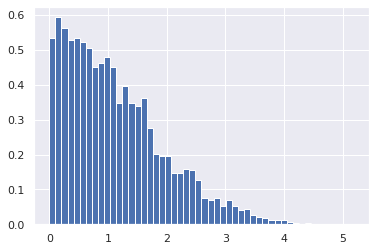

In [71]:
plt.hist(squareform(df, checks=False), bins=50, density=True);

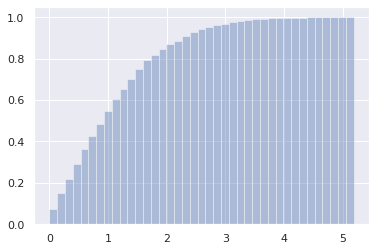

In [88]:
sns.distplot(squareform(df, checks=False),
             hist_kws=dict(cumulative=True),
             kde=False, norm_hist=True);

In [101]:
correlations = sorted(np.abs(squareform(df, checks=False))) # must be positive
cumsum = np.cumsum(correlations) / sum(correlations)
plt.plot(correlations, cumsum);

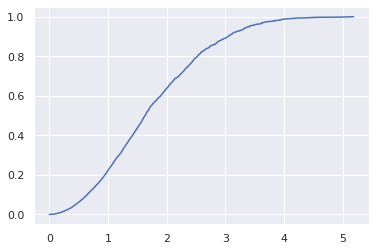

In [111]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [110]:
np.cumsum(range(10))

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])